### Imports for Model

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from IPython import display
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import sys
FUENTES_DIR = "/lib"
sys.path.append(FUENTES_DIR)

DATOS_DIR = "data/"
import os
import requests
from datetime import date, datetime, timedelta

# Asegurar carpeta de datos
os.makedirs(DATOS_DIR, exist_ok=True)

# Parámetros de periodo: primer día de marzo 2025 hasta hoy
START_DATE = "2025-03-10"
END_DATE = date.today().isoformat()

# Ruta local para guardar el CSV crudo
raw_csv_path = os.path.join(DATOS_DIR, 'training.csv')

# URL remota a consultar
remote_url = f"http://localhost:8080/?start={START_DATE}&end={END_DATE}"

# Flags: forzar descarga o re-procesado (poner True para forzar)
FORCE_DOWNLOAD = False
FORCE_REPROCESS = False

if FORCE_DOWNLOAD and os.path.exists(raw_csv_path):
    os.remove(raw_csv_path)

print("remote_url: ", remote_url)

if not os.path.exists(raw_csv_path):
    print(f"Descargando datos de {remote_url} ...")
    try:
        resp = requests.get(remote_url, timeout=30)
        resp.raise_for_status()
        with open(raw_csv_path, 'wb') as f:
            f.write(resp.content)
        print(f"Guardado CSV en {raw_csv_path}")
    except Exception as e:
        print("Error descargando datos desde localhost:", e)
        raise
else:
    print(f"Archivo CSV crudo ya existe en {raw_csv_path}")

data = pd.read_csv(raw_csv_path)

2025-11-01 18:55:39.095462: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-01 18:55:39.097092: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-01 18:55:39.234554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-01 18:55:41.620608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

remote_url:  http://localhost:8080/?start=2025-03-10&end=2025-11-01
Archivo CSV crudo ya existe en data/training.csv


### Preprocessing 

In [2]:

from lib.preprocessing import preprocess_data

data = preprocess_data(data)

# Separar features y labels
X = data.drop(columns=["consumption"])
T = data["consumption"]

data['daylight'].value_counts()

0   2025-03-10 03:00:00+00:00
1   2025-03-10 03:05:00+00:00
2   2025-03-10 03:10:00+00:00
3   2025-03-10 03:15:00+00:00
4   2025-03-10 03:20:00+00:00
Name: date, dtype: datetime64[ns, UTC]
0   2025-03-10 09:45:51+00:00
1   2025-03-10 09:45:51+00:00
2   2025-03-10 09:45:51+00:00
3   2025-03-10 09:45:51+00:00
4   2025-03-10 09:45:51+00:00
Name: sunrise_dt, dtype: datetime64[ns, UTC]
0   2025-03-10 22:18:04+00:00
1   2025-03-10 22:18:04+00:00
2   2025-03-10 22:18:04+00:00
3   2025-03-10 22:18:04+00:00
4   2025-03-10 22:18:04+00:00
Name: sunset_dt, dtype: datetime64[ns, UTC]


daylight
1    31727
0    27912
Name: count, dtype: int64

In [3]:
from lib.normalization import normalize_data

X_train, X_test, T_train, T_test = normalize_data(X, T)

### Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

model = Sequential([
    Dense(12, activation='relu', input_dim=X_train.shape[1]),
    Dense(8, activation='relu'),
    Dense(1, activation='relu')  # salida ReLU para regresión
])

optimizer = optimizers.Adam(learning_rate=0.001)  # mucho más eficiente que SGD

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()


/home/gblas/Developer/STR/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-01 18:55:42.916962: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [5]:
es = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001)


history = model.fit(X_train, T_train,batch_size=64,
                    epochs=800,
                    verbose=0,
                    validation_data=(X_test, T_test),callbacks=[es])

# Guardar modelo
model.save('models/energy_consumption_model.keras')

### Evaluation

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Loss de test: 270525.1250, Métrica: 399.9695
373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


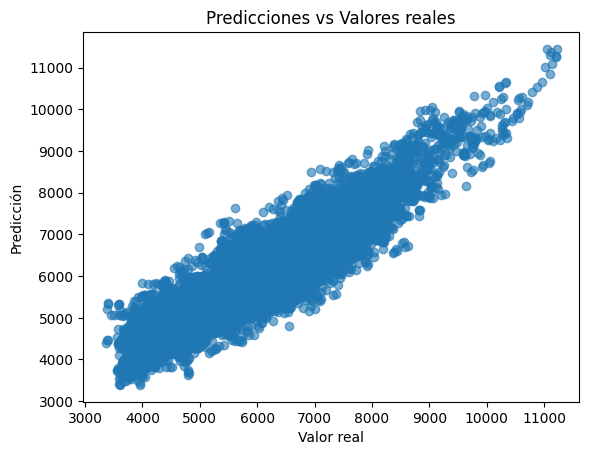

In [ ]:
pred_scaled = model.predict(X_test)
pred = pred_scaled
T_real = T_test

# Evaluación del modelo
loss, metric = model.evaluate(X_test, T_test, verbose=0)
print(f"Loss de test: {loss:.4f}, Métrica: {metric:.4f}")
# TODO: modificar esto
# Predicciones
y_pred = model.predict(X_test)

plt.scatter(T_real, pred, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicciones vs Valores reales")
plt.show()

In [ ]:
# Hardcoded inference example
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Payload hardcodeado (proveído por el usuario)
payload = {
    "date": "2025-11-01T16:50Z",
    "temperature": 26.11,
    "humidity": 49,
    "rain": 0.0,
    "snow": 0.0,
    "pressure": 1013.0,
    "wind_speed": 2.47,
    "wind_direction": 358,
    "clouds": 100,
    "sunrise": 1761986859,
    "sunset": 1762035786,
    "working_day": False,
    "holiday": False,
}

# Construir DataFrame de una fila
row = {
    "date": [payload.get("date")],
    "temperature": [payload.get("temperature")],
    "humidity": [payload.get("humidity")],
    "rain": [payload.get("rain")],
    "snow": [payload.get("snow")],
    "pressure": [payload.get("pressure")],
    "wind_speed": [payload.get("wind_speed")],
    "wind_direction": [payload.get("wind_direction")],
    "clouds": [payload.get("clouds")],
    "sunrise": [int(payload.get("sunrise"))],
    "sunset": [int(payload.get("sunset"))],
    "working_day": [payload.get("working_day")],
    "holiday": [payload.get("holiday")],
}

df = pd.DataFrame(row)
# Aplicar preprocesamiento (usa la función definida en lib/preprocessing.py)
try:
    df_proc = preprocess_data(df)
except Exception as e:
    print("Error en preprocesamiento:", e)
    raise

# Preparar X para la inferencia
X_inf = df_proc.values

# Cargar modelo
model_path = os.path.join('models', 'energy_consumption_model.keras')
if not os.path.exists(model_path):
    print(f"Modelo no encontrado en {model_path}. Ejecuta la celda de training antes para crearlo.")
else:
    model = load_model(model_path)
    print("Modelo cargado.")

    # Escalado: si existe X_train en el kernel (ejecutaste entrenamiento), lo usamos para ajustar el scaler,
    # si no, escalamos localmente (advertencia: escalar con una sola muestra es poco fiable).
    try:
        scaler = StandardScaler()
        if 'X_train' in globals():
            print("Ajustando scaler sobre X_train existente en el notebook...")
            scaler.fit(X_train)
            X_scaled = scaler.transform(X_inf)
        else:
            print("No se encontró X_train en el entorno. Haciendo fit_transform sobre la muestra (precario).")
            X_scaled = scaler.fit_transform(X_inf)
    except Exception as e:
        print("Error al escalar features:", e)
        X_scaled = X_inf

    # Predicción (sin ninguna desnormalización)
    pred = model.predict(X_scaled)
    # Mostrar la predicción tal cual (sin inverse_transform)
    try:
        print(f"Predicción de consumo energético (sin desnormalizar): {pred.reshape(-1)[0]:.2f} unidades.")
    except Exception:
        print("Predicción de consumo energético (sin desnormalizar):", pred)


0   2025-11-01 16:50:00+00:00
Name: date, dtype: datetime64[ns, UTC]
0   2025-11-01 08:47:39+00:00
Name: sunrise_dt, dtype: datetime64[ns, UTC]
0   2025-11-01 22:23:06+00:00
Name: sunset_dt, dtype: datetime64[ns, UTC]
Modelo cargado.
Ajustando scaler sobre X_train existente en el notebook...
Error al escalar features: name 'X_inf' is not defined


NameError: name 'X_inf' is not defined